# Feature Detection

**Download the required data from the google drive**

In [66]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# download the image
!gdown --id '1G9JZlNPuHfR_TZjkQaFifSfqZ48WeNUV' --output image.jpg

Downloading...
From: https://drive.google.com/uc?id=1G9JZlNPuHfR_TZjkQaFifSfqZ48WeNUV
To: /content/image.jpg
100% 977/977 [00:00<00:00, 2.88MB/s]


## 1. Harris Corner Detection
Basic definitions:

$$
M = g(\sigma_I)*
    \begin{bmatrix}
    I_x^2(\sigma_D) & I_xI_y(\sigma_D)\\\\
    I_xI_y(\sigma_D) & I_y^2(\sigma_D)
    \end{bmatrix}
$$

1. large eigenvalues and small ratio
2. we know
$$
detM = \lambda_1\lambda_2 \\\\
traceM = \lambda_1 + \lambda_2
$$

3. leads to

$$
R = detM - k \cdot trace^2(M) > T
$$


###Simply use the function cv2.cornerHarris() in openCV can achieve the purpose
this part shows how it works, all you need to do here is to run it and see the result

Originl image:


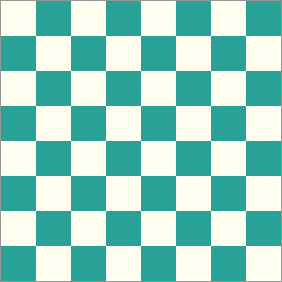

Image after Harris Corner Detector:


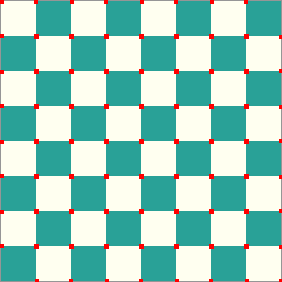

In [67]:
# use openCV to read the image and change it into a grayscale one
filename = 'image.jpg'
img = cv2.imread(filename)
print("Originl image:")
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert to float32
gray = np.float32(gray)
# use the function cv2.cornerHarris() to detect the corners
dst = cv2.cornerHarris(gray,2,3,0.04)
# result is dilated for marking the corners, not important 
# you can run the code again without this command and compare the result
dst = cv2.dilate(dst, None)
# once the pixel is specified as a corner(when the value is greater than threshold), 
# change it into a red dot(here we assume the threshold is equal to 0.01*dst.max())
img[dst>0.02*dst.max()]=[0,0,255]
# show the image image
print("Image after Harris Corner Detector:")
cv2_imshow(img)

###Step by step to create a Harris corner detection

Step1 : Color to grayscale

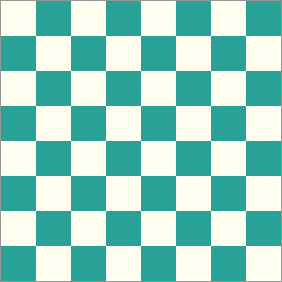

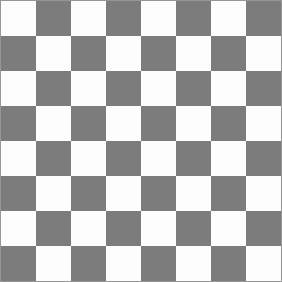

In [68]:
# use openCV to read the image and show it
filename = 'image.jpg'
img = cv2.imread(filename)
cv2_imshow(img)

# change it into a grayscale one then show it
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
cv2_imshow(gray)

Step 2: Spatial derivative calculation

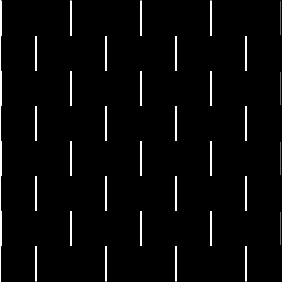

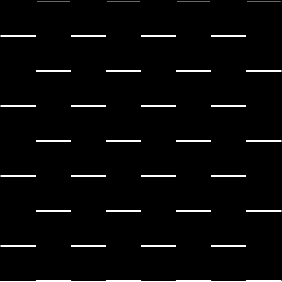

In [69]:
# Ix & Iy are image derivatives in x and y directions respectively.
# can easily calculated by using sobel kernel
# the input is an array representing the image
# the return is an array representing the image derivatives  
# hint: image derivatives are the same as the calculation of the gradient in sobel detection
def gradient_x(input):
  #create a numpy zeros array whose shape should be same as the input image
  I_x = np.zeros(input.shape)
  #create a sobel x-component filter
  sobel_x=np.array([-1,0,1,
                    -2,0,2,
                    -1,0,1]).reshape(3,3)  
  #Pad the input image with zeros.
  input_padding=np.pad(input,int(sobel_x.shape[0]/2),'constant') 

  #Apply the Sobel filter. Avoid processing outside the boundary. 
  for row in range(int(sobel_x.shape[0]/2),input_padding.shape[0]-int(sobel_x.shape[0]/2)):
    for col in range(int(sobel_x.shape[1]/2),input_padding.shape[1]-int(sobel_x.shape[1]/2)):
      I_x[row-int(sobel_x.shape[0]/2),col-int(sobel_x.shape[1]/2)] = np.sum(input_padding[row-int(sobel_x.shape[0]/2):row+int(sobel_x.shape[0]/2)+1,
                              col-int(sobel_x.shape[1]/2):col+int(sobel_x.shape[1]/2)+1]*sobel_x)
  return I_x

def gradient_y(input):
  #create the numpy zeros array and its shape like input image
  I_y = np.zeros(input.shape)
  #create the sobel y-component filter
  sobel_y=np.array([1,2,1,
                    0,0,0,
                    -1,-2,-1]).reshape(3,3)

  #padding the input image with zeros ann the width equal to the filter center to the boundary
  input_padding=np.pad(input,int(sobel_y.shape[0]/2),'constant') 

  #do the Sobel filter and avoid processing outside the boundary
  for row in range(int(sobel_y.shape[0]/2),input_padding.shape[0]-int(sobel_y.shape[0]/2)):
    for col in range(int(sobel_y.shape[1]/2),input_padding.shape[1]-int(sobel_y.shape[1]/2)):
      I_y[row-int(sobel_y.shape[0]/2),col-int(sobel_y.shape[1]/2)] = np.sum(input_padding[row-int(sobel_y.shape[0]/2):row+int(sobel_y.shape[0]/2)+1,
                              col-int(sobel_y.shape[1]/2):col+int(sobel_y.shape[1]/2)+1]*sobel_y)   
  return I_y
# get the image derivatives in x and y directions respectively
I_x = gradient_x(gray)
I_y = gradient_y(gray)

# show the image of I_x & I_y
cv2_imshow(I_x)
cv2_imshow(I_y)

Step 3: Structure tensor setup
$$
M = g(\sigma_I)*
    \begin{bmatrix}
    I_x^2(\sigma_D) & I_xI_y(\sigma_D)\\\\
    I_xI_y(\sigma_D) & I_y^2(\sigma_D)
    \end{bmatrix}
  =  
    \begin{bmatrix}
    Ixx & Ixy\\\\
    Ixy & Iyy
    \end{bmatrix}
$$

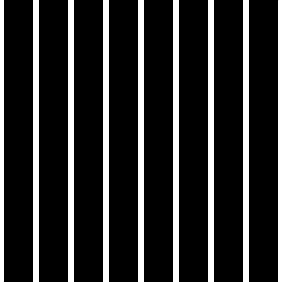

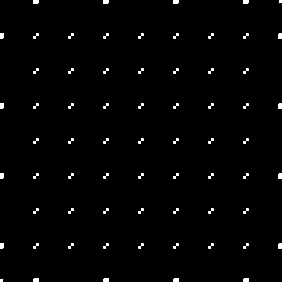

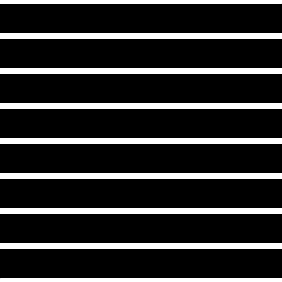

In [70]:
# the matrix M is composed of the image second derivatives after Gaussian filter with kernel size = 5*5 & σ = 1
# hint: the function cv2.GaussianBlur() is for this purpose
Ixx = cv2.GaussianBlur(I_x*I_x, (5, 5), 1)
Ixy = cv2.GaussianBlur(I_x*I_y, (5, 5), 1)
Iyy = cv2.GaussianBlur(I_y*I_y, (5, 5), 1)

# show the image of Ixx, Ixy & Iyy
cv2_imshow(Ixx)
cv2_imshow(Ixy)
cv2_imshow(Iyy)

Step 4: Harris response calculation

$$
R = detM - k \cdot trace^2(M) > T
$$


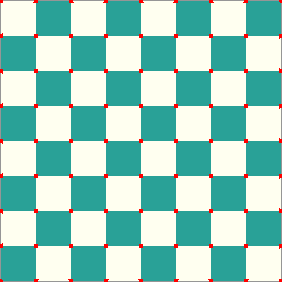

In [71]:
# calculate R
detA = Ixx * Iyy - Ixy ** 2
traceA = Ixx + Iyy

# k: empirical constant, here we use 0.04
k = 0.04
R = detA - k * traceA ** 2

# copy the image and then use it to be labeled
img_copy = img.copy()

# once the pixel is specified as a corner(when the value is greater than threshold), 
# change it into a red dot(here we assume the threshold is equal to 0.01*R.max())
for row, response in enumerate(R):
    for col, r in enumerate(response):
        if r > 0.01*R.max():
            img_copy[row, col] = [0,0,255]

# show the image
cv2_imshow(img_copy)

## Feature space
A a good feature is characterized by: 

* Repeatability (got to be able to find it again)
* Distinctiveness/informativeness (features representing different things need to be different)
* Locality (they need to be local to the image feature and not, like, the whole image)
* Quantity (you need to be able to find enough of them for them to be properly useful)
* Accuracy (they need to accurately locate the image feature)
* Efficiency (they've got to be computable in reasonable time)

In [79]:
# Import libraries
import cv2 # Opencv
import numpy as np # Matrix manipulations

# the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (15, 12) # this controls figure size in the notebook

--2021-03-25 08:25:08--  http://www.ntuce-newsletter.tw/vol.35/images/03.jpg
Resolving www.ntuce-newsletter.tw (www.ntuce-newsletter.tw)... 52.9.64.94
Connecting to www.ntuce-newsletter.tw (www.ntuce-newsletter.tw)|52.9.64.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216715 (212K) [image/jpeg]
Saving to: ‘cee.jpg’

cee.jpg             100%[===================>] 211.64K   986KB/s    in 0.2s    

2021-03-25 08:25:08 (986 KB/s) - ‘cee.jpg’ saved [216715/216715]



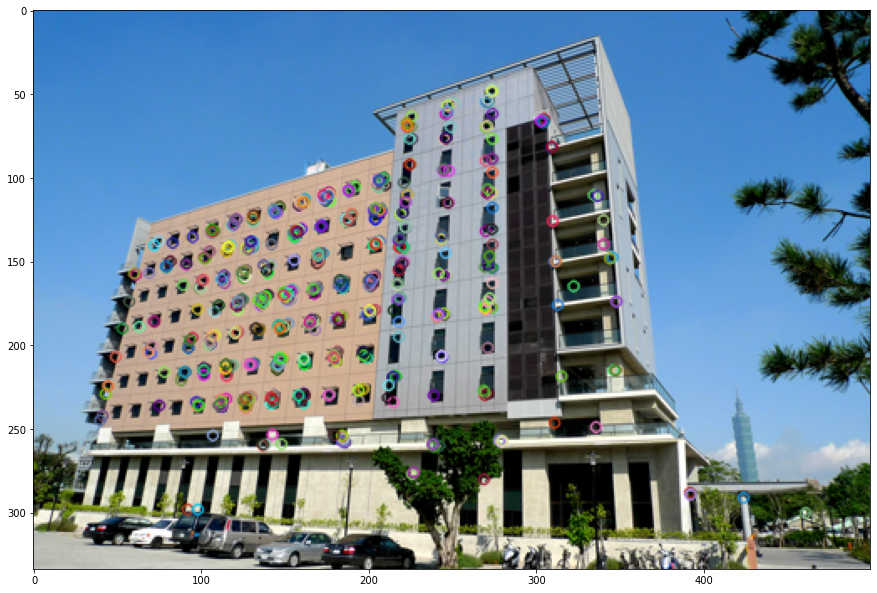

In [80]:
!wget "http://www.ntuce-newsletter.tw/vol.35/images/03.jpg" -O cee.jpg
input_image = cv2.imread('./cee.jpg')
# copy the image 
ntuce_copy = input_image.copy()

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and compute the descriptors with ORB
# hint: detect() and compute() in openCV are for the purposes
# find the keypoints with ORB
kp = orb.detect(ntuce_copy,None)

# compute the descriptors with ORB
kp, des = orb.compute(ntuce_copy, kp)

# draw keypoints by using cv2.drawKeypoints()
ntuce_detected = cv2.drawKeypoints(ntuce_copy,kp,None)

# show the image with plt, remember to notice the color channel
ntuce_detected = cv2.cvtColor(ntuce_detected, cv2.COLOR_BGR2RGB)
plt.imshow(ntuce_detected)

In [81]:
# download the files and save into two files
!wget "http://www.ntuce-newsletter.tw/vol.35/images/03.jpg" -O cee_1.jpg
!wget "http://www.ntuce-newsletter.tw/vol.35/images/03.jpg" -O cee_2.jpg

--2021-03-25 08:25:09--  http://www.ntuce-newsletter.tw/vol.35/images/03.jpg
Resolving www.ntuce-newsletter.tw (www.ntuce-newsletter.tw)... 52.9.64.94
Connecting to www.ntuce-newsletter.tw (www.ntuce-newsletter.tw)|52.9.64.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216715 (212K) [image/jpeg]
Saving to: ‘cee_1.jpg’

cee_1.jpg           100%[===================>] 211.64K   983KB/s    in 0.2s    

2021-03-25 08:25:10 (983 KB/s) - ‘cee_1.jpg’ saved [216715/216715]

--2021-03-25 08:25:10--  http://www.ntuce-newsletter.tw/vol.35/images/03.jpg
Resolving www.ntuce-newsletter.tw (www.ntuce-newsletter.tw)... 52.9.64.94
Connecting to www.ntuce-newsletter.tw (www.ntuce-newsletter.tw)|52.9.64.94|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216715 (212K) [image/jpeg]
Saving to: ‘cee_2.jpg’

cee_2.jpg           100%[===================>] 211.64K   982KB/s    in 0.2s    

2021-03-25 08:25:10 (982 KB/s) - ‘cee_2.jpg’ saved [216715/216715]



In [82]:
# read the image respectively
bridge_img_1 = cv2.imread('cee_1.jpg') # used for the 50% one
bridge_img_2 = cv2.imread('cee_2.jpg') # used for the discarded bottom half one

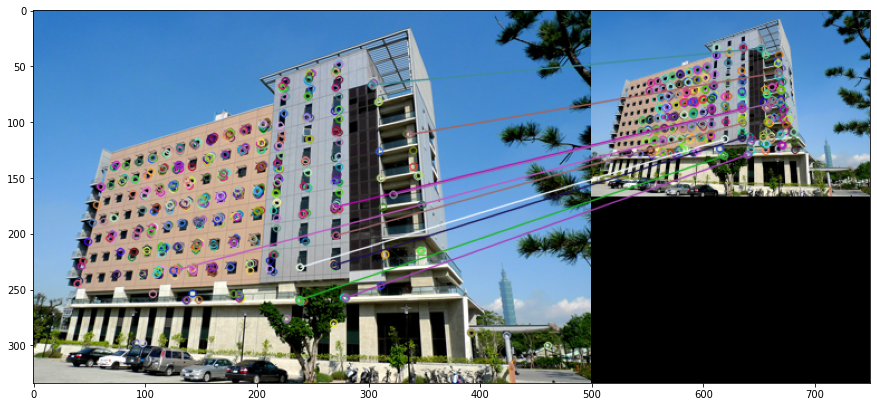

In [83]:
# turn the image into 50%
bridge_img_1 = cv2.resize(bridge_img_1, (int(bridge_img_1.shape[1]/2), int(bridge_img_1.shape[0]/2)), interpolation=cv2.INTER_AREA)

# find the keypoints
orb = cv2.ORB_create()
kp1 = orb.detect(bridge_img_1,None)

# compute the descriptors with ORB
kp1, des1 = orb.compute(bridge_img_1, kp1)

# create BFMatcher object: this is a Brute Force matching object
bf1 = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)

# Match descriptors.
matches = bf1.match(des,des1)
 
# Sort them by distance between matches in feature space - so the best matches are first.
matches = sorted(matches,key=lambda x:x.distance)
 
# Draw first 10 matches.
matches_10 = matches[:10]

# Show the image with plt, remember to notice the color channel
img_match_1 = cv2.drawMatches(img1 = ntuce_copy,
                       keypoints1 = kp,
                       img2 = bridge_img_1,
                       keypoints2 = kp1,
                       matches1to2 = matches_10,
                       outImg = None) 

img_match_1 = cv2.cvtColor(img_match_1, cv2.COLOR_BGR2RGB)
plt.imshow(img_match_1)

The steps of this part is the same as the above one, but the object is the other image. Follow the steps and see what the difference is

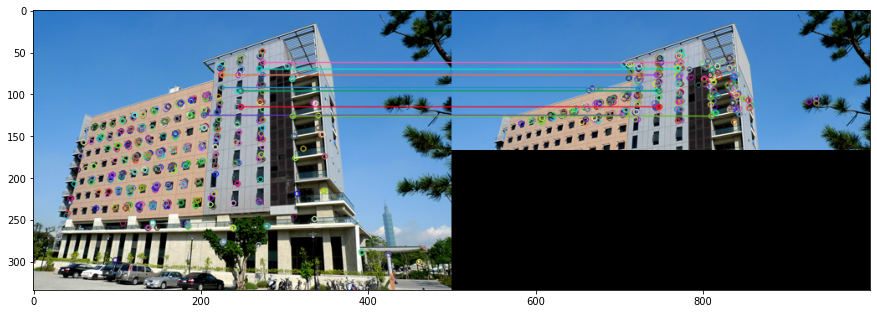

In [84]:
# discard the bottom half part of the image
bridge_img_2 = bridge_img_2[0:int(bridge_img_2.shape[0]/2), 0:int(bridge_img_2.shape[1])]

# find the keypoints
kp2 = orb.detect(bridge_img_2,None)

# compute the descriptors with ORB
kp2, des2 = orb.compute(bridge_img_2, kp2)

# create BFMatcher object: this is a Brute Force matching object
bf2 = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)

# Match descriptors.
matches2 = bf2.match(des,des2)
 
# Sort them by distance between matches in feature space - so the best matches are first.
matches2 = sorted(matches2,key=lambda x:x.distance)
 
# Draw first 10 matches.
matches2_10 = matches2[:10]

# Show the image with plt, remember to notice the color channel
img_match_2 = cv2.drawMatches(img1 = ntuce_copy,
                       keypoints1 = kp,
                       img2 = bridge_img_2,
                       keypoints2 = kp2,
                       matches1to2 = matches2_10,
                       outImg = None) 

img_match_2 = cv2.cvtColor(img_match_2, cv2.COLOR_BGR2RGB)
plt.imshow(img_match_2)